In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [2]:
%pip install \
simplet5 \
rouge --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 23.7.3 requires setuptools>=60.0.0, but you have setuptools 59.5.0 which is incompatible.
opentelemetry-api 1.18.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 6.7.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from simplet5 import SimpleT5
from transformers import T5Tokenizer, PegasusForConditionalGeneration, PegasusTokenizer, AdamW, get_linear_schedule_with_warmup
from rouge import Rouge
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings("ignore") 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## EDA

In [4]:
df = pd.read_csv("/kaggle/input/news-summary/news_summary.csv", encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
df = df[['ctext','text']]
df.head()

,ctext,text
0,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TV?appearances, Bo...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...


In [7]:
df.columns = ['source_text', 'target_text']
df = df.dropna()
# T5 model expects a task related prefix: since it is a summarization task, we will add a prefix "summarize: "
df['source_text'] = "summarize: " + df['source_text']
df.head()

,source_text,target_text
0,summarize: The Daman and Diu administration on...,The Administration of Union Territory Daman an...
1,summarize: From her special numbers to TV?appe...,Malaika Arora slammed an Instagram user who tr...
2,summarize: The Indira Gandhi Institute of Medi...,The Indira Gandhi Institute of Medical Science...
3,summarize: Lashkar-e-Taiba's Kashmir commander...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,summarize: Hotels in Mumbai and other Indian c...,Hotels in Maharashtra will train their staff t...


In [8]:
df.iloc[1]['source_text']

'summarize: From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster debut opposite Shah Rukh Khan in Chaiyya Chaiyya from Dil Se (1998), is still remembered for the song. However, for trolls, she is a woman first and what matters right now is that she divorced a ?rich man?.  On Wednesday, Malaika Arora shared a gorgeous picture of herself on Instagram and a follower decided to troll her for using her ?alumni? (read alimony) money to wear ?short clothes and going to gym or salon?. Little did he/she know that the Munni Badnam star would reply with the perfect comeback. Take a look at the interaction:     Super excited to be affiliated with Khanna Jewellers @khannajewellerskj as their brand ambassador. Crafted to perfection, their stunning statement jewellery is a must have for every jewellery lover. #khannajewellers...#maksquad?? #hair @hairbypriyank

In [9]:
df.iloc[1]['target_text']

'Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoying vacation[s]," the user commented. Malaika responded, "You certainly got to get your damn facts right before spewing sh*t on me...when you know nothing about me."'

In [10]:
source_text_length = [len(x.split()) for x in df.source_text]
target_text_length = [len(x.split()) for x in df.target_text]

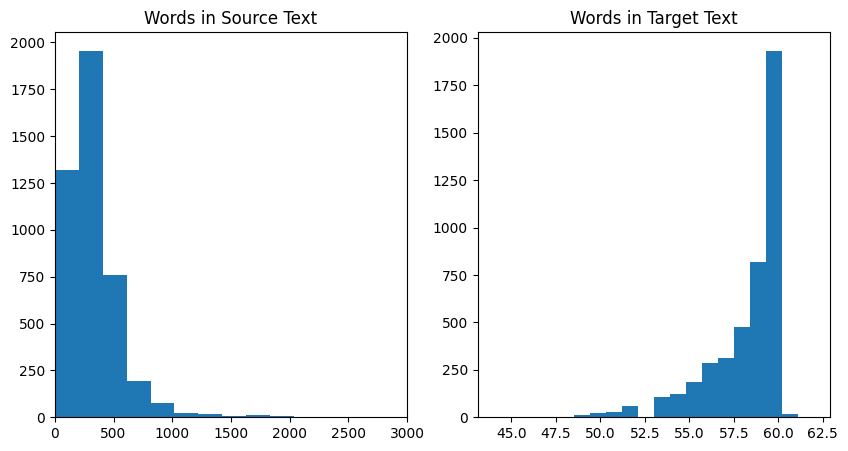

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(source_text_length, bins = 60)
ax2.hist(target_text_length, bins = 20)
ax1.set_xlim([0, 3000])

ax1.title.set_text("Words in Source Text")
ax2.title.set_text("Words in Target Text")
plt.show()

In [12]:
train_df, tmp_df = train_test_split(df, test_size=0.2, random_state = 42)
val_df, test_df = train_test_split(tmp_df, test_size=0.03, random_state = 42)
print(f"Shape of the Train Set: {train_df.shape}\nShape of the Val Set: {val_df.shape}\nShape of the Test Set: {test_df.shape}")

Shape of the Train Set: (3516, 2)
Shape of the Val Set: (853, 2)
Shape of the Test Set: (27, 2)


## Simple T5 Zero-shot Learning

https://github.com/Shivanandroy/simpleT5

In [13]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

model = SimpleT5()

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

In [14]:
model.from_pretrained(model_type="t5", model_name="t5-base")

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [17]:
model.device= torch.device("cpu")

In [18]:
index = 200

news = train_df.iloc[index]['source_text']
summary = train_df.iloc[index]['target_text']

prompt = news

#inputs = tokenizer(prompt, return_tensors='pt')
output = model.predict(prompt)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
summarize: Los Angeles, Jul 2 (PTI) Rapper Kanye West, who is a key player in Jay-Zs music streaming service, Tidal, has left the company over money dispute. West, 40, was reportedly unhappy with the company for a long time, sources told TMZ. "Were told Kanye has complained the company owes him money -- more than USD 3 million," the sources added. 
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Rapper Kanye West has reportedly quit Jay-Z's music streaming startup Tidal over a dispute regarding money. According to reports, West complained that Tidal owes him over ?19.4 crore. Tidal has also been accused of going back on its promise of reimbursing West for music videos, but the startup said that West didn't deliver the videos required by the contract.

------------------------------------------------

In [19]:
text_summaries = test_df['target_text'].tolist()

In [22]:
text_summaries[1]

'Actress Disha Patani was stalked by a male fan when she was in Delhi for a brand shoot recently. The man reportedly reached Disha\'s hotel on two consecutive days to meet her and also kept following her to the sets. "I am relieved that the episode is over... It was an unpleasant experience," said Disha. '

In [20]:
model_summaries = []
for x in range(len(test_df)):
    model_summary = model.predict(test_df['source_text'].iloc[x])
    
    model_summaries.append(model_summary)

Token indices sequence length is longer than the specified maximum sequence length for this model (883 > 512). Running this sequence through the model will result in indexing errors


In [28]:
len(model_summaries)

27

In [21]:
model_summaries[1]

['two-film-old Disha Patani was stalked by a male fan when she was in Delhi for a brand shoot. the man reached her hotel on two consecutive days to meet her.']

In [23]:
model_summaries = [str(summary) for summary in model_summaries]
text_summaries = [str(summary) for summary in text_summaries]

rouge = Rouge()
rouge.get_scores(model_summaries, text_summaries, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.2781984528857429,
  'p': 0.4158680333190033,
  'f': 0.32742555100857207},
 'rouge-2': {'r': 0.11253795332707436,
  'p': 0.19091803859776882,
  'f': 0.13895745914268795},
 'rouge-l': {'r': 0.25361505268928153,
  'p': 0.38150469893539285,
  'f': 0.29922943053776097}}

## Fine-tunning T5

In [24]:
model.train(train_df=train_df, 
            eval_df=val_df,  
            source_max_token_len=400, 
            target_max_token_len=120, 
            batch_size=8, max_epochs=2, use_gpu=True, 
            early_stopping_patience_epochs=2)

Validation sanity check: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
filepath = "model.pt"

# save the model
torch.save(model, filepath)

In [26]:
model1 = torch.load('model.pt', map_location=torch.device('cpu'))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
model1_summaries = []
for x in range(len(test_df)):
    model1_summary = model1.predict(test_df['source_text'].iloc[x])
    
    model1_summaries.append(model1_summary)

In [30]:
model1_summaries = [str(summary) for summary in model1_summaries]
rouge1 = Rouge()
rouge1.get_scores(model1_summaries, text_summaries, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.4301327841670777,
  'p': 0.4136517079242883,
  'f': 0.4200363937309855},
 'rouge-2': {'r': 0.19497390625788283,
  'p': 0.19898946018835464,
  'f': 0.19564397196502234},
 'rouge-l': {'r': 0.38745327762271903,
  'p': 0.3728377059414025,
  'f': 0.37848785915080496}}

# Pegasus Zero-shot Learning 

In [31]:
class SummarizationDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=512, max_output_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        article = self.data.iloc[index]["source_text"]
        summary = self.data.iloc[index]["target_text"]
        input_ids = self.tokenizer.encode(article, max_length=self.max_input_length, truncation=True, padding="max_length")
        output_ids = self.tokenizer.encode(summary, max_length=self.max_output_length, truncation=True, padding="max_length")
        return {"input_ids": input_ids, "attention_mask": [int(token_id != 0) for token_id in input_ids], "decoder_input_ids": output_ids[:-1], "decoder_attention_mask": [1] * (len(output_ids) - 1), "labels": output_ids[1:]}

In [32]:
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

In [33]:
train_dataset = SummarizationDataset(train_df, tokenizer)
val_dataset = SummarizationDataset(val_df, tokenizer)

In [34]:
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    decoder_input_ids = [item["decoder_input_ids"] for item in batch]
    decoder_attention_mask = [item["decoder_attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]
    max_input_length = max(len(ids) for ids in input_ids)
    max_output_length = max(len(ids) for ids in decoder_input_ids)
    input_ids = [ids + [0] * (max_input_length - len(ids)) for ids in input_ids]
    attention_mask = [mask + [0] * (max_input_length - len(mask)) for mask in attention_mask]
    decoder_input_ids = [ids + [0] * (max_output_length - len(ids)) for ids in decoder_input_ids]
    decoder_attention_mask = [mask + [0] * (max_output_length - len(mask)) for mask in decoder_attention_mask]
    labels = [ids + [-100] * (max_output_length - len(ids)) for ids in labels]
    return {"input_ids": torch.tensor(input_ids), "attention_mask": torch.tensor(attention_mask), "decoder_input_ids": torch.tensor(decoder_input_ids), "decoder_attention_mask": torch.tensor(decoder_attention_mask), "labels": torch.tensor(labels)}

In [35]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2,collate_fn=collate_fn)

In [36]:
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=10000)

In [37]:
len(train_loader),len(val_loader)

(1758, 427)

In [38]:
test_dataset = SummarizationDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=1,collate_fn=collate_fn)

In [17]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
predictions = []
with torch.no_grad():
    for step, batch in tqdm(enumerate(test_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_ids = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], max_length=128, decoder_start_token_id=tokenizer.pad_token_id)
        batch_predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids]
        predictions.extend(batch_predictions)

27it [01:32,  3.42s/it]


In [18]:
len(predictions)

27

In [20]:
predictions[1]

"The actor was stalked by a male fan when she was in Delhi for a brand shoot recently, Mid-Day reports.Reportedly, the man reached Disha's hotel on two consecutive days to meet her."

In [15]:
text_summaries = test_df['target_text'].tolist()

In [22]:
len(text_summaries)

27

In [23]:
text_summaries[1]

'Actress Disha Patani was stalked by a male fan when she was in Delhi for a brand shoot recently. The man reportedly reached Disha\'s hotel on two consecutive days to meet her and also kept following her to the sets. "I am relieved that the episode is over... It was an unpleasant experience," said Disha. '

In [24]:
rouge = Rouge()
rouge.get_scores(predictions, text_summaries, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.3348012081471132,
  'p': 0.31331167261659626,
  'f': 0.30951607430729416},
 'rouge-2': {'r': 0.13114754941521875,
  'p': 0.13798785486642903,
  'f': 0.12496224629423736},
 'rouge-l': {'r': 0.3078104428197441,
  'p': 0.2925503859472582,
  'f': 0.2863736451193394}}

## Fine-Tune Pegasus

In [39]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
for epoch in range(5):
    train_loss = 0
    for step,batch in tqdm(enumerate(train_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if step%100==0 and step>0:
            print("Step-{},Train Loss-{}".format(step,loss.item()))
            break#intentionally breaking the training after 100 steps since it's going to take long to train,feel free to comment and train more
        train_loss += loss.item()
    train_loss /= len(train_loader)
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for step,batch in tqdm(enumerate(val_loader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            loss = model(**batch).loss
            val_loss += loss.item()
            if step%100==0 and step>0:
                print("Step-{},Val Loss-{}".format(step,loss.item()))
                break #intentionally breaking the training after 100 steps since it's going to take long to validate,feel free to comment and validate more
        val_loss /= len(val_loader)
    model.train()
    #break # when you train more then comment this, too !
    print(f"Epoch {epoch+1} train loss: {train_loss:.4f} val loss: {val_loss:.4f}")

100it [00:49,  2.01it/s]


Step-100,Train Loss-9.737411499023438


100it [00:14,  6.87it/s]


Step-100,Val Loss-9.451358795166016
Epoch 1 train loss: 0.5891 val loss: 2.1108


100it [00:49,  2.01it/s]


Step-100,Train Loss-8.1351318359375


100it [00:14,  6.87it/s]


Step-100,Val Loss-7.323578357696533
Epoch 2 train loss: 0.4871 val loss: 1.6302


100it [00:49,  2.01it/s]


Step-100,Train Loss-6.877303600311279


100it [00:14,  6.87it/s]


Step-100,Val Loss-6.5146989822387695
Epoch 3 train loss: 0.3971 val loss: 1.4134


100it [00:49,  2.01it/s]


Step-100,Train Loss-6.461528778076172


100it [00:14,  6.85it/s]


Step-100,Val Loss-6.091065406799316
Epoch 4 train loss: 0.3555 val loss: 1.3161


100it [00:49,  2.02it/s]


Step-100,Train Loss-5.893712520599365


100it [00:14,  6.86it/s]

Step-100,Val Loss-5.7732038497924805
Epoch 5 train loss: 0.3285 val loss: 1.2513


In [40]:
model.save_pretrained("fine_tuned_pegasus")
tokenizer.save_pretrained("fine_tuned_pegasus")

('fine_tuned_pegasus/tokenizer_config.json',
 'fine_tuned_pegasus/special_tokens_map.json',
 'fine_tuned_pegasus/spiece.model',
 'fine_tuned_pegasus/added_tokens.json')

In [41]:
model1 = PegasusForConditionalGeneration.from_pretrained("fine_tuned_pegasus")
tokenizer1 = PegasusTokenizer.from_pretrained("fine_tuned_pegasus")

In [42]:
model1.to(device)
model1.eval()
predictions1 = []
with torch.no_grad():
    for step, batch in tqdm(enumerate(test_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_ids = model1.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], 
                                     max_length=128, decoder_start_token_id=tokenizer1.pad_token_id)
        batch_predictions = [tokenizer1.decode(ids, skip_special_tokens=True) for ids in output_ids]
        predictions1.extend(batch_predictions)

27it [00:40,  1.50s/it]


In [43]:
len(predictions1)

27

In [44]:
predictions1[1]

'"It was an unpleasant experience."While the actor did not register a complaint, she has decided to have a bodyguard with her at all times as a safety measure.'

In [45]:
text_summaries[1]

'Actress Disha Patani was stalked by a male fan when she was in Delhi for a brand shoot recently. The man reportedly reached Disha\'s hotel on two consecutive days to meet her and also kept following her to the sets. "I am relieved that the episode is over... It was an unpleasant experience," said Disha. '

In [46]:
rouge1 = Rouge()
rouge1.get_scores(predictions1, text_summaries, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.20813218732817115,
  'p': 0.3783655028485915,
  'f': 0.26198247742410957},
 'rouge-2': {'r': 0.08244496900888683,
  'p': 0.1761839287440784,
  'f': 0.10961149723152303},
 'rouge-l': {'r': 0.19078320261495665,
  'p': 0.3486484276919211,
  'f': 0.24068996220101344}}